<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/PVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A super simple tutorial on a simple idea: Understanding Dataset Difficulty with  $\mathcal{V}$-Usable Information
### Dr. Fayyaz Minhas

Department of Computer Sciene

University of Warwick

I recently read the ICML 2022 paper mentioned in the title -- I must say, it is one of the simplest yet most generalized approach I have seen in quite a while. It allows us to measure the level of difficulty of a dataset for a given machine learning problem. The problem behind the solution is pretty simple but very diverse across application domains: Assume you are given a predictor $f$ whose probability of generating a target $y$ can be denoted by $f(\cdot)_y$. How can we measure the difficulty of a given test example $x$ with known target $y$? Of course, we can use loss functions but then that makes the resulting values difficult to interpret for a different loss function or across datasets. In the paper, they presnet the idea of "point-wise usable information" as an answer to this question. Assume your classifier generates a probability $f(x)_y$ for your inut $x$ with target $y$ but if you present grabled information or a null input $\phi$ then its output probability for target $y$ becomes $f(\phi)_y$ which we expect to be more random or eqiuvaltnty "more entropic". Formally, Point-wise usable information or PVI is simply the difference between entropies $-log_2 f(\phi)_y$ and  $-log_2 f(x)_y$. However, to be fair, the predictor should be retrained over the same training dataset but with "garbled" or null inputs when we want to get its output for a null input at test time. Consequently, to compute PVI, we need to train the predictor twice: firstly with the training data to produce the predictor $f$ and then with null inputs (but true targets) $f_\phi$. PVI is then written as $pvi(x,y) = -log_2 f_\phi(\phi)_y+log_2 f(x)_y$. The overall difficulty of the dataset can then be computed as the average PVI across the test dataset. It can then be used to compare different datasets, classifiers, as well as examples. 

Below I present a simple illustration of this. We use a logistic regression classifier to illustrate this concept. 

The data dimensions are (1100, 2) (1100,)


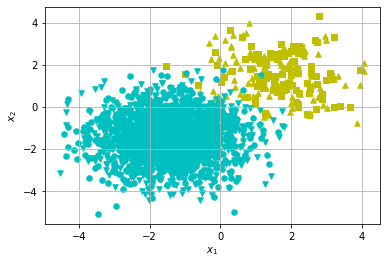

In [47]:
#just plotting code
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plotit(X,Y=None,clf=None, markers = ('s','o'), hold = False, transform = None):
    """
    Just a function for showing a data scatter plot and classification boundary
    of a classifier clf
    """
    minx, maxx = np.min(X[:,0]), np.max(X[:,0])
    miny, maxy = np.min(X[:,1]), np.max(X[:,1])
    if clf is not None:
        npts = 100
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf.decision_function(t)
        z = np.reshape(z,(npts,npts))
        
        extent = [minx,maxx,miny,maxy]
        plt.imshow(z,vmin = -2, vmax = +2)    
        plt.contour(z,[-1,0,1],linewidths = [2],colors=('b','k','r'),extent=extent, label='f(x)=0')
        plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.axis([minx,maxx,miny,maxy])   
    if Y is not None:
        plt.scatter(X[Y==1,0],X[Y==1,1],marker = markers[0], c = 'y', s = 30)
        plt.scatter(X[Y==-1,0],X[Y==-1,1],marker = markers[1],c = 'c', s = 30)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')        
         
    else:
        plt.scatter(X[:,0],X[:,1],marker = '.', c = 'k', s = 5)
    if not hold:
        plt.grid()
        plt.show()
#Let's generate some training data
def getExamples(pos = 100, neg = 100, gap = 0.5):
  Xp = gap+np.random.randn(pos,2)
  Xn = -gap-np.random.randn(neg,2)
  X = np.vstack((Xp,Xn))
  Y = np.array([1]*Xp.shape[0]+[-1]*Xn.shape[0])
  return X,Y

X,Y = getExamples(pos = 100, neg = 1000, gap = 1.5)
print ('The data dimensions are',X.shape, Y.shape)

plotit(X,Y, hold = True)
#Let's generate some test data

Xt,Yt = getExamples(pos = 100, neg = 1000, gap = 1.5)

plotit(Xt, Yt, markers = ('^','v'))

Let's implement the approach with a simple logisitc regression classifier. In the actual paper, they have used deep language models to show that the approach is extendible to any predictor $f(x)$ for which we can compute the probability of generating a target $y$ as $f(x)_y$ -- thinkin any neural network that can generate a probability for any input-output pair $f(x,y)$. However, here we keep things simple!

Let's check the average PVI when the gap between the two classes is large...

Average PVI 0.40043206256137637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'label'


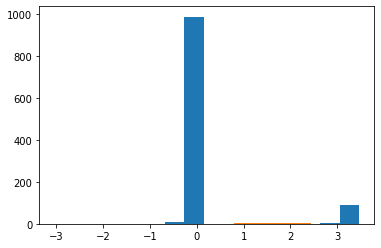

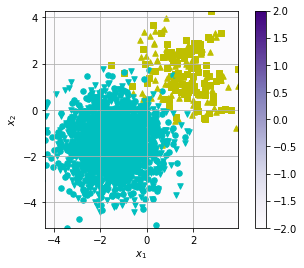

In [48]:
from scipy.special import expit as logistic
from sklearn.linear_model import LogisticRegression
#X,Y is the training data
#Xt,Yt is the test data (from same distribution as X,Y)
#clf,clf_null are the classifiers for training data and null data respectively
#here we generate a null example as an "average" training example from that dataset
clf = LogisticRegression(random_state=16).fit(X, Y) #real classifier
Xmean = np.mean(X,axis=0)
Xnull = Xmean*np.ones(X.shape)
clf_null = LogisticRegression(random_state=16).fit(Xnull, Y) #null or dummy classifier
gny = logistic(clf_null.decision_function(Xt)) #null classifier's output f_\phi(\phi)_1
gny[Yt==-1] = 1-gny[Yt==-1] #compute probability for negative examples
gz = clf.decision_function(Xt) 
gy = logistic(gz) #classifier's output f(x)_1
gy[Yt==-1] = 1-gy[Yt==-1] #compute probability for negative examples
pvi = -np.log2(gny)+np.log2(gy) #compute pvi
iv = np.mean(pvi) #compute usable information
plt.hist(pvi[gz*Yt>0]) #plot histogram for correctly classified examples 
plt.hist(pvi[gz*Yt<0]) #plot histogram incorrectly classified
print("Average PVI", iv)
plt.figure() #plot the data
plotit(X,Y, clf_null, hold = True)
plotit(Xt,Yt, markers = ('^','v')) 

As you can see, the average PVI is large. Let's shrink the gap between the two classes.

The data dimensions are (1100, 2) (1100,)
Average PVI 0.11354223654146112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'label'


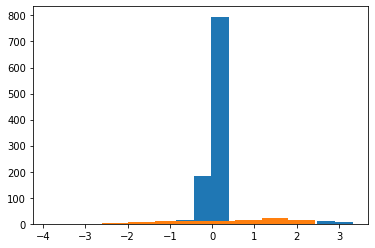

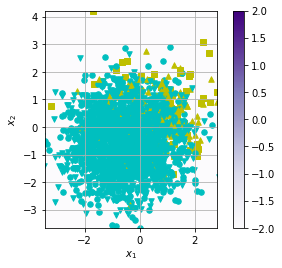

In [49]:
#Let's reduce the gap
X,Y = getExamples(pos = 100, neg = 1000, gap = 0.5)
print ('The data dimensions are',X.shape, Y.shape)
Xt,Yt = getExamples(pos = 100, neg = 1000, gap = 0.5)
clf = LogisticRegression(random_state=16).fit(X, Y) #real classifier
Xmean = np.mean(X,axis=0)
Xnull = Xmean*np.ones(X.shape)
clf_null = LogisticRegression(random_state=16).fit(Xnull, Y) #null or dummy classifier
gny = logistic(clf_null.decision_function(Xt)) #null classifier's output f_\phi(\phi)_1
gny[Yt==-1] = 1-gny[Yt==-1] #compute probability for negative examples
gz = clf.decision_function(Xt) 
gy = logistic(gz) #classifier's output f(x)_1
gy[Yt==-1] = 1-gy[Yt==-1] #compute probability for negative examples
pvi = -np.log2(gny)+np.log2(gy) #compute pvi
iv = np.mean(pvi) #compute usable information
plt.hist(pvi[gz*Yt>0]) #plot histogram for correctly classified examples 
plt.hist(pvi[gz*Yt<0]) #plot histogram incorrectly classified
print("Average PVI", iv)
plt.figure() #plot the data
plotit(X,Y, clf_null, hold = True)
plotit(Xt,Yt, markers = ('^','v')) 

As expected the average PVI decreases. Note that the resulting PVI is independnet of the class ratio as well as the classifier type. However, these are left as exercises for the reader!